In [1]:
import sys
import tensorflow as tf
import numpy as np
from google.colab import drive
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/CommonSwissBirds

/content/drive/MyDrive/CommonSwissBirds


In [4]:
%ls

01_data_prep/   04_resnet_50/         07_VGG16/       utils/
02_data/        05_efficientNetV2L/   08_custom_CNN/
03_base_model/  06_mobileNetV3_mini/  readme.ipynb


In [5]:
sys.path.append('./utils')
import utils

In [6]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 1
GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-1cf8b9d4-c4be-a03d-502c-ac62d41c9638)


In [7]:
class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.


In [9]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 5000 files belonging to 10 classes.
Using 1000 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/test_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
)

Found 1222 files belonging to 10 classes.


In [11]:
showcase_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/showcase_images',
    labels='inferred',
    label_mode='int',
    class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube'],
    color_mode='rgb',
    shuffle=False,
    batch_size=30,
    image_size=(224, 224),
)


Found 30 files belonging to 10 classes.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
showcase_ds = showcase_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
base_model = VGG16(weights='imagenet', include_top=False)
model = utils.recompile_custom_output(base_model)

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
callbacks = [EarlyStopping(monitor='val_accuracy', mode = "max", patience=2),
ModelCheckpoint(
    filepath=r'./07_VGG16/model/best.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [15]:
# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=50,
  callbacks=[callbacks],
)

Epoch 1/50
125/125 [==============================] - 129s 888ms/step - loss: 2.6298 - accuracy: 0.6780 - val_loss: 0.5594 - val_accuracy: 0.8220
Epoch 2/50
125/125 [==============================] - 4s 35ms/step - loss: 0.4400 - accuracy: 0.8813 - val_loss: 0.2484 - val_accuracy: 0.9340
Epoch 3/50
125/125 [==============================] - 4s 34ms/step - loss: 0.2455 - accuracy: 0.9415 - val_loss: 0.4451 - val_accuracy: 0.8910
Epoch 4/50
125/125 [==============================] - 5s 38ms/step - loss: 0.2157 - accuracy: 0.9523 - val_loss: 0.2323 - val_accuracy: 0.9620
Epoch 5/50
125/125 [==============================] - 4s 34ms/step - loss: 0.1284 - accuracy: 0.9693 - val_loss: 0.2541 - val_accuracy: 0.9550
Epoch 6/50
125/125 [==============================] - 4s 34ms/step - loss: 0.1229 - accuracy: 0.9737 - val_loss: 0.3370 - val_accuracy: 0.9470


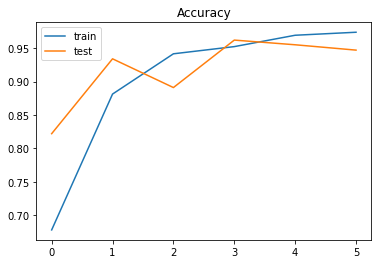

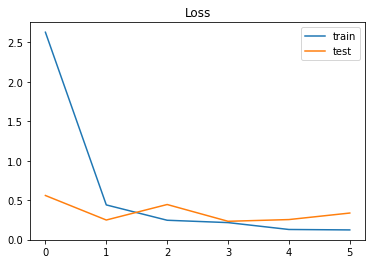

In [16]:
%matplotlib inline
utils.plot_history(history)

In [17]:
callbacks = [EarlyStopping(monitor='val_accuracy', mode = "max", patience=2),
ModelCheckpoint(
    filepath=r'./07_VGG16/model/best_finetuned.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [18]:
for layer in base_model.layers:
    layer.trainable = True

# recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again 
histroy = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=50,
  callbacks=[callbacks]
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


125/125 [==============================] - 12s 73ms/step - loss: 0.0846 - accuracy: 0.9793 - val_loss: 0.3456 - val_accuracy: 0.9340
Epoch 2/50
125/125 [==============================] - 9s 72ms/step - loss: 0.0440 - accuracy: 0.9905 - val_loss: 0.2338 - val_accuracy: 0.9520
Epoch 3/50
125/125 [==============================] - 10s 76ms/step - loss: 0.0130 - accuracy: 0.9983 - val_loss: 0.2182 - val_accuracy: 0.9620
Epoch 4/50
125/125 [==============================] - 9s 71ms/step - loss: 0.0111 - accuracy: 0.9987 - val_loss: 0.2209 - val_accuracy: 0.9580
Epoch 5/50
125/125 [==============================] - 9s 71ms/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 0.2189 - val_accuracy: 0.9610


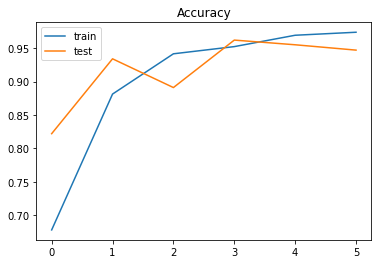

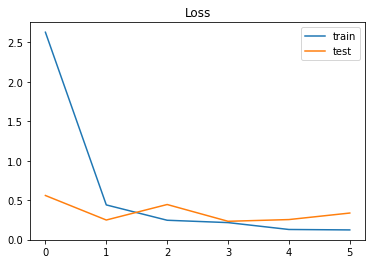

In [19]:
%matplotlib inline
utils.plot_history(history)

In [13]:
# Possible to start here without training... just loading the new weights...
base_model = VGG16(weights='imagenet', include_top=False)
model = utils.recompile_custom_output(base_model)
model.load_weights('./07_VGG16/model/best_finetuned.h5')

In [21]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
39/39 [==============================] - 28s 714ms/step - loss: 0.4767 - accuracy: 0.9296
test loss, test acc: [0.47669726610183716, 0.929623544216156]


In [14]:
testset_predictions = model.predict(test_ds)
predicted_labels = [prediction.argmax() for prediction in testset_predictions]
true_labels = utils.get_labels_from_categorical_batch_dataset(test_ds)
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

39/39 [==============================] - 4s 29ms/step


In [15]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       0.98      0.87      0.92       113
     blaumeise       0.93      0.92      0.93       125
      buchfink       0.90      0.97      0.93       125
        elster       0.95      0.96      0.96       113
hausrotschwanz       0.90      0.95      0.92       117
     hausspatz       0.87      0.89      0.88       133
     kohlmeise       0.92      0.95      0.93       125
   rabenkraehe       1.00      0.90      0.95       121
          star       0.92      0.93      0.92       125
  tuerkentaube       0.95      0.95      0.95       125

      accuracy                           0.93      1222
     macro avg       0.93      0.93      0.93      1222
  weighted avg       0.93      0.93      0.93      1222



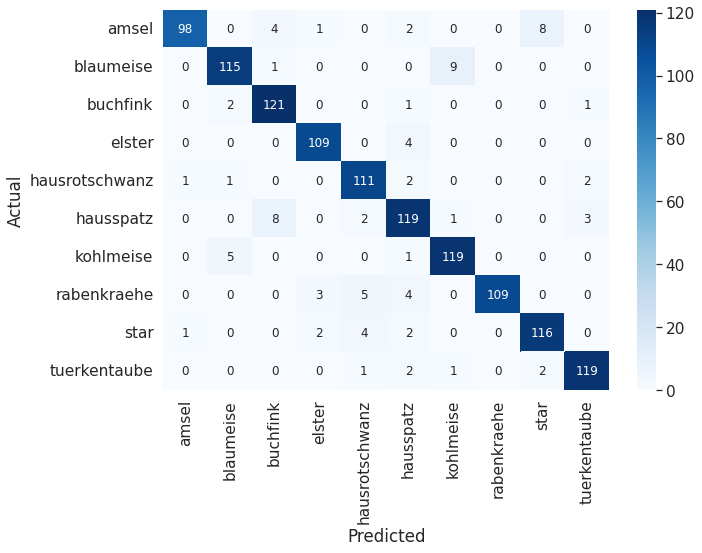

In [16]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

In [17]:
showcase_predictions = model.predict(showcase_ds)
predicted_labels = [prediction.argmax() for prediction in showcase_predictions]
true_labels = [label.numpy() for label in [labels for images, labels in showcase_ds.take(1)][0]]
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

1/1 [==============================] - 1s 701ms/step


In [18]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       1.00      1.00      1.00         3
     blaumeise       1.00      1.00      1.00         3
      buchfink       1.00      1.00      1.00         3
        elster       0.75      1.00      0.86         3
hausrotschwanz       0.75      1.00      0.86         3
     hausspatz       1.00      0.67      0.80         3
     kohlmeise       1.00      1.00      1.00         3
   rabenkraehe       1.00      0.67      0.80         3
          star       1.00      1.00      1.00         3
  tuerkentaube       1.00      1.00      1.00         3

      accuracy                           0.93        30
     macro avg       0.95      0.93      0.93        30
  weighted avg       0.95      0.93      0.93        30



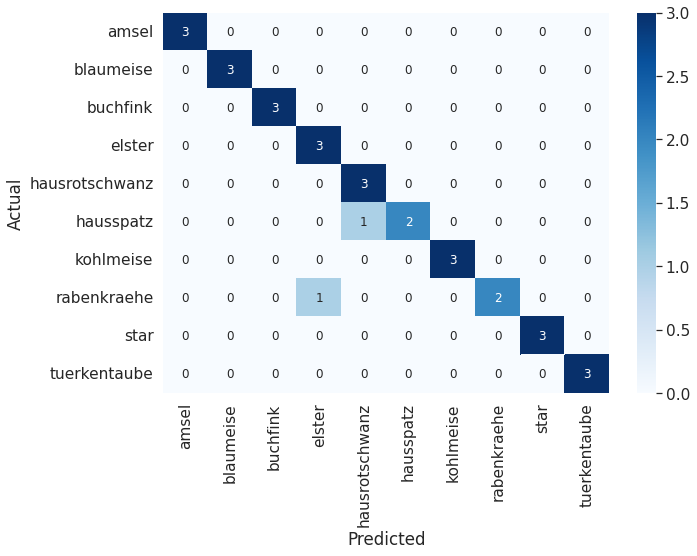

In [19]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

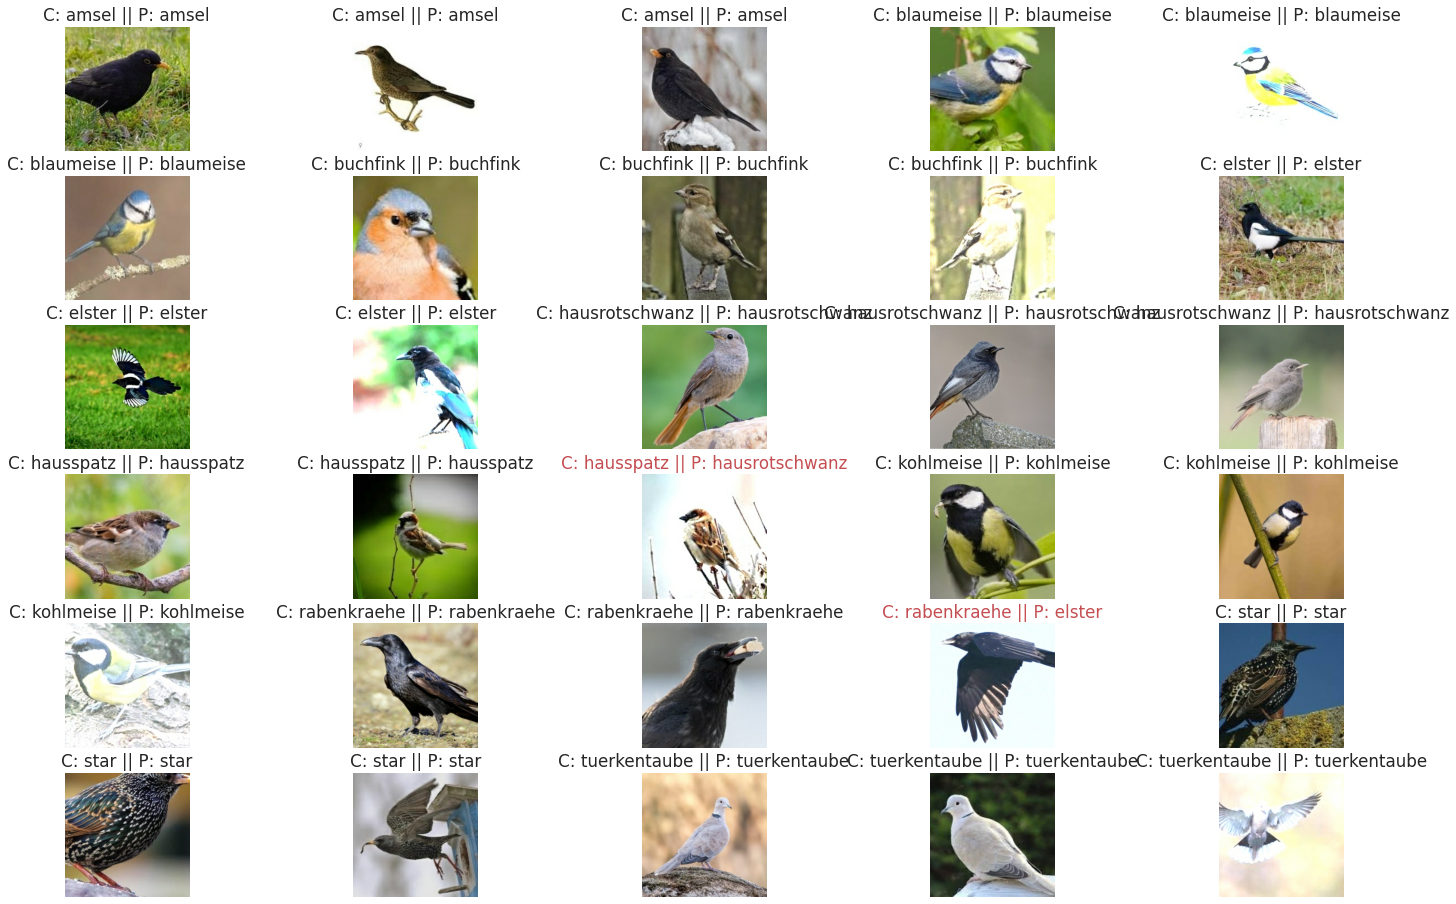

In [20]:
%matplotlib inline
utils.plot_showcase(showcase_ds, class_names, showcase_predictions)

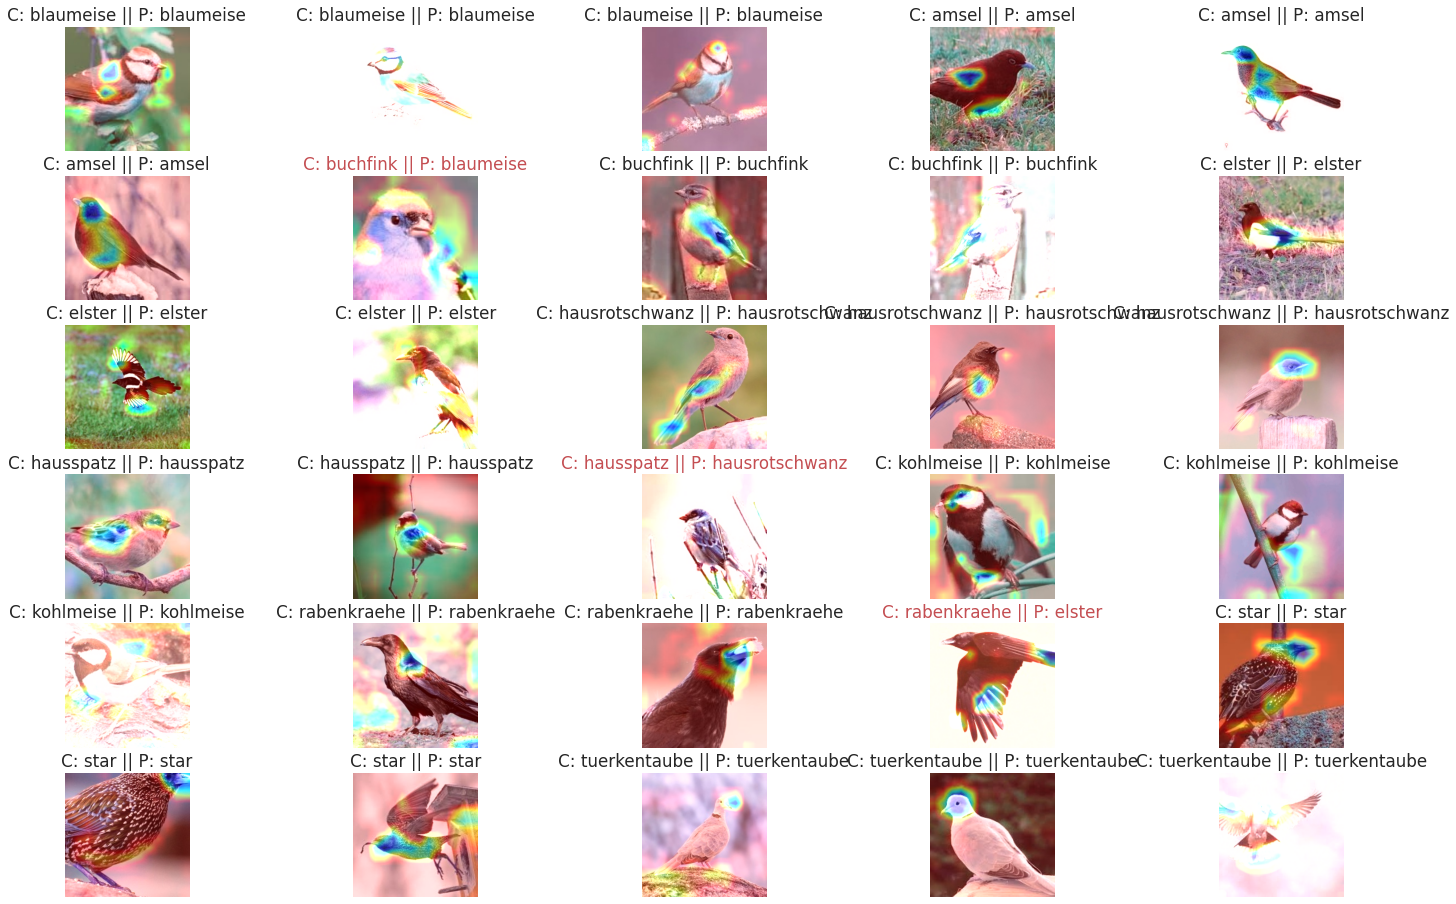

In [31]:
showcase_path = './02_data/99_dataset_preparation/showcase_images'
last_convolution_layer_name = 'block5_conv3'
utils.plot_showcase_gradcam_overlay(showcase_path, class_names, model, last_convolution_layer_name, (14,14))

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     